In [57]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import cfe.regression as rgsn

Missing dependencies for OracleDemands.


### data clean up

In [3]:
Phillippines_Data = '1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY'

In [4]:
InputFiles = {'Expenditures':(Phillippines_Data,'Expenditures'),
              'HH Characteristics':(Phillippines_Data,'HH Characteristics'),
              'FCT':(Phillippines_Data,'FCT'),
              'Quantities':(Phillippines_Data,'Quantities'),
             'Prices Per Household':(Phillippines_Data,'Prices Per Household')}
InputFiles

{'Expenditures': ('1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY',
  'Expenditures'),
 'HH Characteristics': ('1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY',
  'HH Characteristics'),
 'FCT': ('1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY', 'FCT'),
 'Quantities': ('1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY', 'Quantities'),
 'Prices Per Household': ('1WmIn1GGsZKv9w96fug6fQAQH9GJwkatYMZRoBgB1GqY',
  'Prices Per Household')}

In [5]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
import warnings

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
# Get prices
p = get_clean_sheet(InputFiles['Prices Per Household'][0],
                    sheet=InputFiles['Prices Per Household'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','i', 'm'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

for i in p.columns:
    p[i] = p[i].median()

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

c = read_sheets(Phillippines_Data,sheet = 'Code Match ')
c.rename(columns ={'Code ' :'fct'}, inplace = True)
fct = fct.merge(c, how = 'inner', on = 'fct').drop(columns = ['Member', 'Food ', 'bouisfg', 'foodgrp'], axis = 1)
fct = fct.set_index('name')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

warnings.filterwarnings('default')

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.

In [6]:
import cfe
import numpy as np

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.to_pickle('phillippines_estimates.pickle')
result = cfe.read_pickle('phillippines_estimates.pickle')  # Get persistent result saved above...

In [7]:
%matplotlib notebook

x_1d = x.groupby('j',axis=1).sum()
x_1d = x_1d.replace(0,np.nan) # Replace zeros with missing

y = np.log(x_1d)

from cfe.estimation import drop_columns_wo_covariance
y = drop_columns_wo_covariance(y,min_obs=30)

y = y.stack()

In [8]:
import cfe

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

### Manually reduced the food items to match the FCT code

In [10]:
# translate qhat names to match fct names
translate = get_clean_sheet(Phillippines_Data, sheet='Code Match ')

translate = translate.drop(['Member', ''], axis=1)

translate = translate[translate['Food'].isin(list(qhat.columns))]

fct_names = fct[fct['fct'].isin(list(translate['Code']))].reset_index()[['name', 'fct']]

translate_names = translate.merge(fct_names, left_on='Code', right_on='fct')
names_dict = dict(zip(list(translate_names['Food']), list(translate_names['name'])))

qhat_fct = qhat.rename(columns=names_dict)

Key available for students@eep153.iam.gserviceaccount.com.


/tmp/ipykernel_1247/2540959960.py:8: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.20.2.39', 59450), raddr=('142.250.159.95', 443)>
  df = read_sheets(key,sheet=sheet)


In [11]:
# select relevant data and remove duplicates
use = fct.index.intersection(qhat_fct.columns)

fct = fct[~fct.index.duplicated(keep='first')].loc[use]
qhat_fct = qhat_fct.loc[:,~qhat_fct.columns.duplicated(keep='first')][use]
qhat_fct

,,j,"Rice milled, white","Corn, yellow","Mango, ripe",Banana,"Bitter melon, boiled",Squash fruit,Tomato,"Sweet potato, yellow",Carrot,Seaweed,...,Sardines canned in oil,"Sugar white, refined","""Kalamansi"" nectar",Corn oil,Soluble coffee,Fish sauce,Coconut vinegar,Milo,Softdrinks,Beer
i,t,m,,,,,,,,,,,,,,,,,,,,,
2.0,2003.0,Bukidnon,17053.503971,74.643002,999.023488,1430.789141,391.342640,646.725219,455.588058,957.764679,623.985324,141.843666,...,326.815415,1112.454402,862.442278,650.263995,20.397007,221.473400,23.398519,95.259586,1361.231553,467.589378
4.0,2003.0,Bukidnon,17014.186862,396.164203,411.124682,976.171927,650.923721,1034.043102,554.505987,2419.182014,589.675182,594.426008,...,462.140288,1188.685532,319.192357,644.791984,38.204560,401.998251,29.270211,112.367171,2035.635537,991.796732
5.0,2003.0,Bukidnon,6541.938988,126.248867,260.014014,333.973326,262.913068,395.645334,179.602497,777.019740,198.521297,184.152011,...,129.577533,535.389724,120.952965,261.567133,12.075665,151.573752,12.139638,50.610025,824.842370,654.024659
6.0,2003.0,Bukidnon,17659.517960,273.488517,550.780633,1183.863641,993.000677,1188.437543,1011.190959,1664.512741,749.145368,629.391888,...,621.406239,1487.143600,1060.863807,787.224508,33.117341,538.745561,37.323828,120.379875,2751.345840,2451.334919
12.0,2003.0,Bukidnon,12252.715179,393.643043,471.738985,853.221166,559.787756,999.261822,410.113476,1663.038430,343.555921,576.337380,...,425.619234,1350.597614,248.885674,588.797634,24.256634,343.290073,39.275725,166.842770,2243.083523,3590.344832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937.0,2003.0,Bukidnon,10199.694209,385.334146,681.199834,735.160679,574.006046,648.272206,359.857046,1017.945685,410.715123,463.825026,...,239.385285,905.185076,320.236474,419.938814,17.934228,226.665787,16.827990,112.710016,1308.016138,885.371474
938.0,2003.0,Bukidnon,12351.640527,290.859517,535.023577,836.705188,526.294259,817.328327,373.385477,1304.015045,363.737175,397.633502,...,304.859049,1021.956322,360.445268,429.392836,24.267126,272.780222,18.507985,117.180304,1598.336104,843.847054
939.0,2003.0,Bukidnon,6159.018422,31.018894,138.877190,107.884131,71.912630,120.018549,75.030844,211.001450,117.613744,27.506125,...,94.399510,355.789979,93.620767,103.465091,4.417256,90.043398,7.190814,16.647666,373.032112,198.912647


### General overview of the nutritional consumption is for the household

In [12]:
# calculate the calorie consumption per household by type of food consumed
consumption_calories = qhat_fct[use]
for col in consumption_calories.columns:
    consumption_calories[col] = consumption_calories[col] * fct['calorie'].loc[col]
consumption_calories

,,j,"Rice milled, white","Corn, yellow","Mango, ripe",Banana,"Bitter melon, boiled",Squash fruit,Tomato,"Sweet potato, yellow",Carrot,Seaweed,...,Sardines canned in oil,"Sugar white, refined","""Kalamansi"" nectar",Corn oil,Soluble coffee,Fish sauce,Coconut vinegar,Milo,Softdrinks,Beer
i,t,m,,,,,,,,,,,,,,,,,,,,,
2.0,2003.0,Bukidnon,6.258636e+06,12465.381292,62938.479715,135924.968403,6261.482246,24575.558326,10478.525324,129298.231637,29951.295567,28226.889471,...,66343.529314,430519.853587,129366.341689,572232.315947,7281.731363,10852.196614,70.195558,37722.796061,53088.030582,19638.753860
4.0,2003.0,Bukidnon,6.244207e+06,66159.421871,25900.854960,92736.333091,10414.779538,39293.637859,12753.637703,326589.571857,28304.408749,118290.775579,...,93814.478557,460021.300959,47878.853525,567416.945669,13639.027985,19697.914309,87.810634,44497.399826,79389.785934,41655.462727
5.0,2003.0,Bukidnon,2.400892e+06,21083.560737,16380.882862,31727.465971,4206.609081,15034.522677,4130.857422,104897.664895,9529.022261,36646.250239,...,26304.239163,207195.823306,18142.944683,230179.076630,4311.012462,7427.113827,36.418914,20041.569720,32168.852424,27469.035661
6.0,2003.0,Bukidnon,6.481043e+06,45672.582351,34699.179859,112467.045860,15888.010830,45160.626622,23257.392052,224709.220058,35958.977640,125248.985632,...,126145.466563,575524.573302,159129.571087,692757.567326,11822.890651,26398.532477,111.971485,47670.430426,107302.487774,102956.066585
12.0,2003.0,Bukidnon,4.496746e+06,65738.388238,29719.556070,81056.010795,8956.604089,37971.949237,9432.609957,224510.188026,16490.684208,114691.138593,...,86400.704461,522681.276546,37332.851044,518141.917974,8659.618510,16821.213578,117.827175,66069.736723,87480.257395,150794.482944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937.0,2003.0,Bukidnon,3.743288e+06,64350.802318,42915.589515,69840.264519,9184.096738,24634.343818,8276.712057,137422.667504,19714.325917,92301.180178,...,48595.212897,350306.624304,48035.471042,369546.156031,6402.519291,11106.623587,50.483969,44633.166282,51012.629389,37185.601903
938.0,2003.0,Bukidnon,4.533052e+06,48573.539349,33706.485329,79486.992907,8420.708136,31058.476427,8587.865982,176042.031139,17459.384407,79129.066816,...,61886.387041,395497.096545,54066.790264,377865.695867,8663.364004,13366.230889,55.523955,46403.400387,62335.108051,35441.576287
939.0,2003.0,Bukidnon,2.260360e+06,5180.155340,8749.262984,10248.992419,1150.602083,4560.704843,1725.709420,28485.195814,5645.459694,5473.718814,...,19163.100540,137690.721842,14043.115020,91049.279730,1576.960454,4412.126510,21.572443,6592.475758,14548.252364,8354.331179


/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



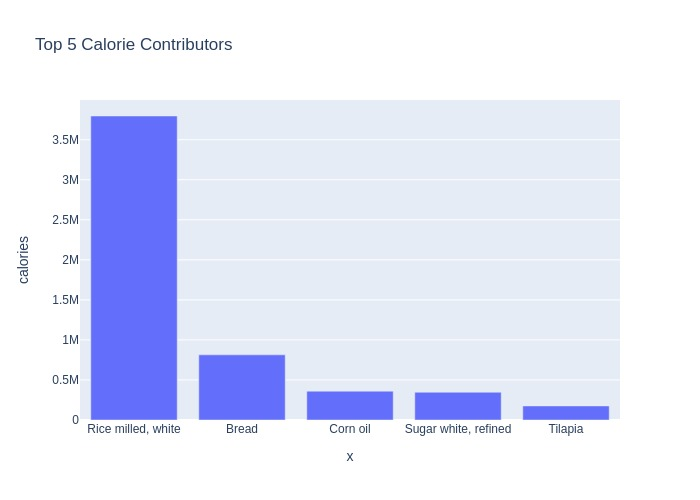

In [15]:
#import seaborn as sns
import plotly.express as px

top5_calorie = pd.DataFrame({'calories': consumption_calories.mean()}).sort_values(by='calories', ascending=False).head(5)
cal_cont = px.bar(top5_calorie, x=list(top5_calorie.index), y=top5_calorie['calories'], title='Top 5 Calorie Contributors')
cal_cont.show('jpg')

# Demands

In [16]:
result.beta.index

Index(['Alcoholic drinks', 'Ampalaya', 'Atsal', 'Bagoong', 'Banana', 'Beef',
       'Calamansi', 'Carrots', 'Chicken', 'Coffee', 'Coke', 'Cooking oil',
       'Corn products', 'Dried fish and smoked fish', 'Eggs',
       'Food made from flour', 'Fresh fish', 'Mangoes', 'Milk', 'Milo',
       'Mongo and other products', 'Okra', 'Onions', 'Petsay', 'Pork',
       'Potato', 'Processed meat like longanisa', 'Rice', 'Rice products',
       'Salt', 'Sardines like youngstown, etc', 'Sea weed', 'Sitao',
       'Snaks like chippy, cheese curls, bread sticks',
       'Soybean and other products', 'Squash', 'Sugar', 'Sweet potato',
       'Talong', 'Tomatoes', 'Vetsin, MSG', 'Vinegar'],
      dtype='object', name='j')

In [17]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index]

In [18]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

### The following codes are used to estimate a system of demands for different kinds of food by defining 'use' as a food of interest and describe demands as function of prices.

In [19]:
def my_prices(p0,p=pbar,j='Rice'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [20]:
result.demands(xref,pbar)

j
Alcoholic drinks                                  106.026147
Ampalaya                                          602.509123
Atsal                                            1034.941413
Bagoong                                            33.060910
Banana                                           1903.304612
Beef                                              180.324567
Calamansi                                        2864.990954
Carrots                                           280.704003
Chicken                                           413.172772
Coffee                                             77.865798
Coke                                              544.017436
Cooking oil                                       399.832003
Corn products                                     122.882550
Dried fish and smoked fish                         57.001429
Eggs                                              732.269398
Food made from flour                              294.363426
Fresh fish            

In [21]:
# To see the demnads of each food item
import plotly.express as px
import pandas as pd
%matplotlib notebook
demand_df = pd.DataFrame({'demand': result.demands(xref,pbar)})
px.bar(demand_df,x=list(result.demands(xref,pbar).index), y=demand_df['demand'], title='Demand for each food product', labels={"x" : 'food items'})

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



<IPython.core.display.Javascript object>


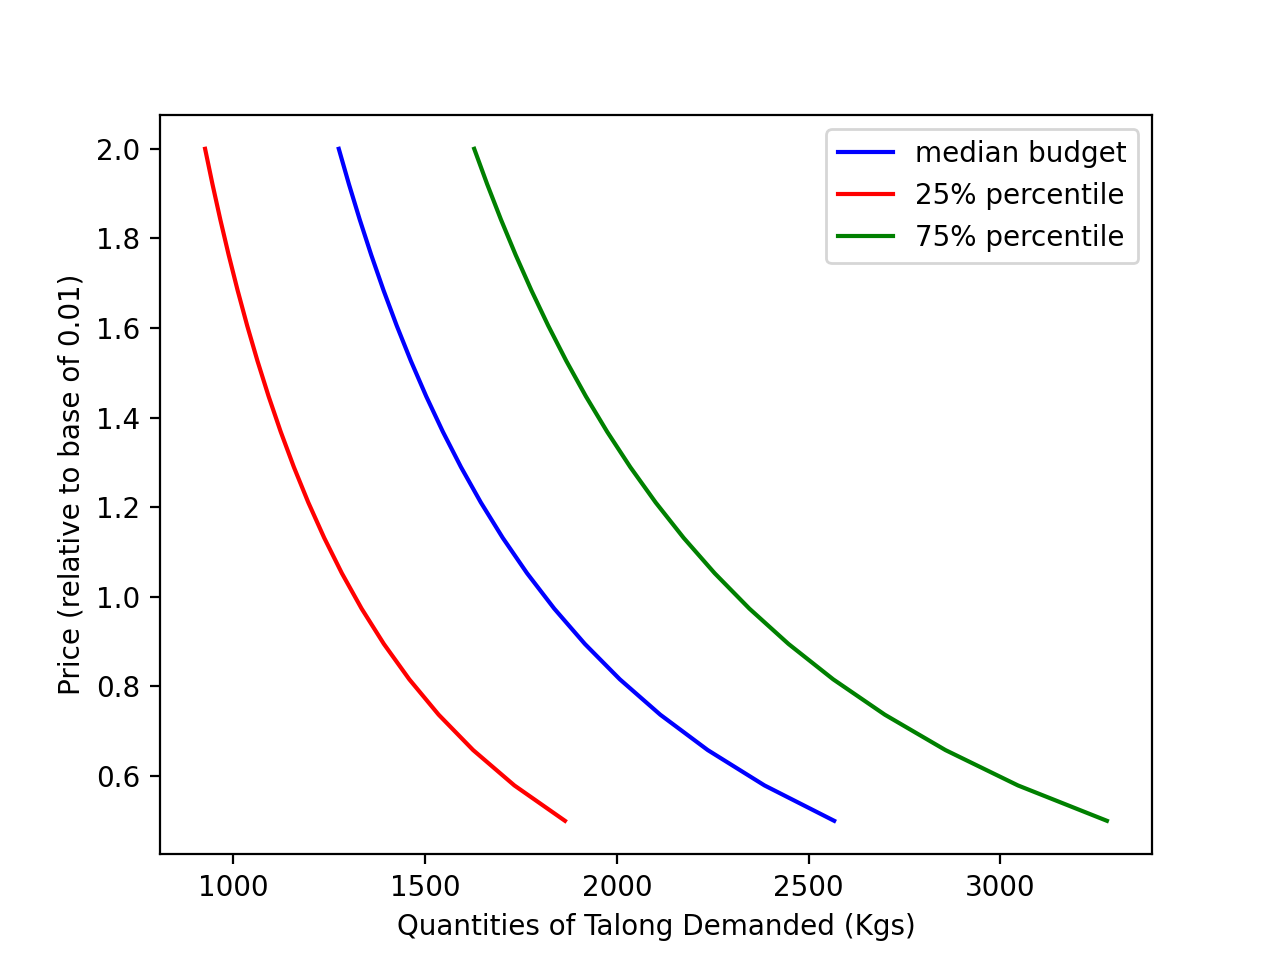

In [22]:
# To see the relative changes in price with varying quantities in demand we can redefine 'use' to food items of interest.
import matplotlib.pyplot as plt

%matplotlib notebook

use = 'Talong'

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Talong for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar,use))[use] for s in scale],scale, color = 'blue', label = 'median budget')

# Demand for Talong for household at 25% percentile denoted in red
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar,use))[use] for s in scale],scale,color = 'red', label = '25% percentile')

# Demand for Talong for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar,use))[use] for s in scale],scale, color = 'green', label = '75% percentile')

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded (Kgs)")
plt.legend()

The visualization represents how household expenditure on a particular goods and services varies with household income.

<IPython.core.display.Javascript object>


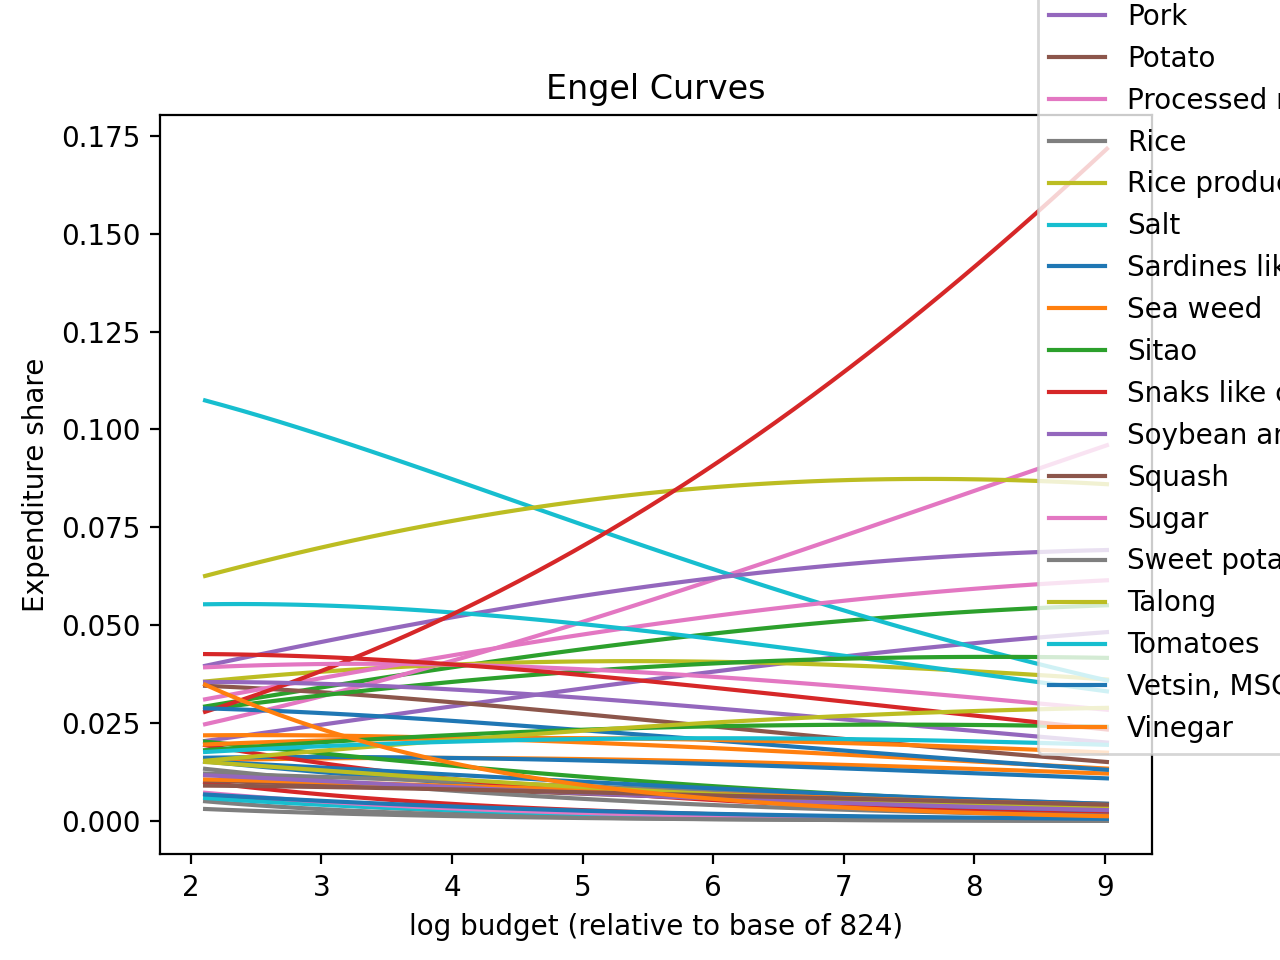

In [30]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')
ax.legend([result.expenditures(s*xref,pbar)/(s*xref) for s in scale][0].index.tolist(), loc = 'best', bbox_to_anchor = (0.8,0.2), bbox_transform = fig.transFigure)

### To look more closely at how the demand in quantities change as a  code describes the quantities demanded as function of budgets to analyze the quntities into nutrients.

In [25]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Okra', 'Milo'], dtype='object')


In [26]:
# The @ operator means matrix multiply
# N describes how much each household consumes each category of nutrients in a week.
N = fct0.T@c0

N

i,2.0,4.0,5.0,6.0,12.0,13.0,14.0,15.0,16.0,17.0,...,931.0,932.0,933.0,935.0,936.0,937.0,938.0,939.0,940.0,941.0
t,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,...,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0,2003.0
m,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,...,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon,Bukidnon
n,,,,,,,,,,,,,,,,,,,,,
fct,445931.461860,610158.045361,171611.808380,546477.952375,378737.573609,252110.922734,169739.328854,400118.154025,622004.676374,301196.313284,...,407446.368603,218450.033039,614245.128301,533431.913065,591573.273489,410385.969212,410770.452173,84266.689300,469699.466411,491590.386816
calorie,189384.716147,170926.572032,58269.943301,184720.045118,153407.100391,78371.169120,64191.649875,135671.504392,168250.185958,106781.392489,...,135256.372383,77081.340296,229099.731296,208411.663851,196447.527878,131700.165011,141569.097671,21625.569884,165510.050613,188437.438019
protein,2886.002008,3496.490619,1008.299202,3272.281796,2271.396039,1456.154399,1029.990515,2283.523126,3547.131477,1849.656268,...,2381.997560,1275.879567,3720.078528,3242.225027,3472.257649,2382.946037,2431.308335,470.249363,2810.231763,3016.668946
fat,1099.339742,1106.701286,401.965113,1168.895948,1131.339385,538.373350,428.662109,1044.778143,1079.126980,632.992014,...,934.051707,561.564674,1521.844801,1424.486585,1334.458205,908.926432,959.985346,147.968785,1095.284708,1219.075070
carbo,46781.042886,41247.654105,13982.472456,44909.629610,36521.432556,18784.232132,15513.575466,31947.191278,40624.485473,26223.099481,...,32435.856589,18343.747302,55399.196306,50213.774227,47234.178967,31564.199272,34073.585316,5162.871571,40003.762514,45770.828809
fiber,860.764369,1180.119425,282.958698,1017.875263,479.737280,437.154830,278.030599,541.766368,1227.176388,597.499165,...,678.835280,320.085694,1022.512228,822.170209,1009.541295,696.300565,689.851288,158.626848,809.158604,841.914472
ash,1747.626194,1870.466296,541.043405,1826.490858,1206.664848,771.902036,572.308906,1150.753990,1893.670970,1070.062854,...,1272.769749,668.692118,2067.333810,1790.244325,1870.584865,1266.758933,1319.128429,242.534713,1548.800667,1706.580469


In [27]:
#N describes nutrient demand based on consumption defined b c and multiplying it by fct of each food category
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

#### The graph here represents the variation of nutrient outcomes with budget with fixed price.

<IPython.core.display.Javascript object>


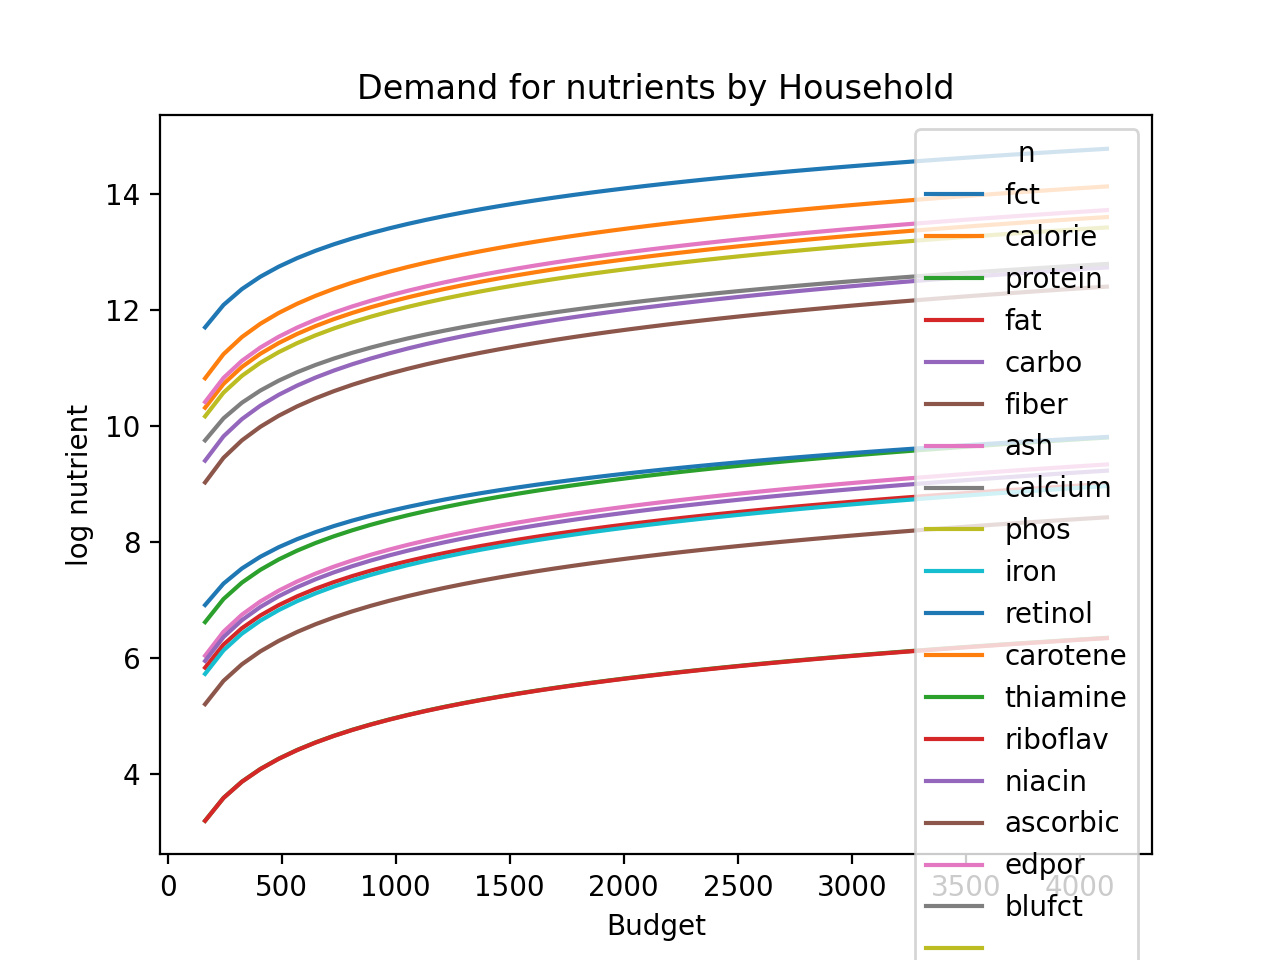

Text(0.5, 1.0, 'Demand for nutrients by Household')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
X = np.linspace(xref/5,xref*5,50)

UseNutrients = fct.columns.tolist()

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()
ax.set_xlabel('Budget')
ax.set_ylabel('log nutrient')
ax.set_title("Demand for nutrients by Household")

#### The visualization shows the varition of nutrition in respect to the prices.

<IPython.core.display.Javascript object>


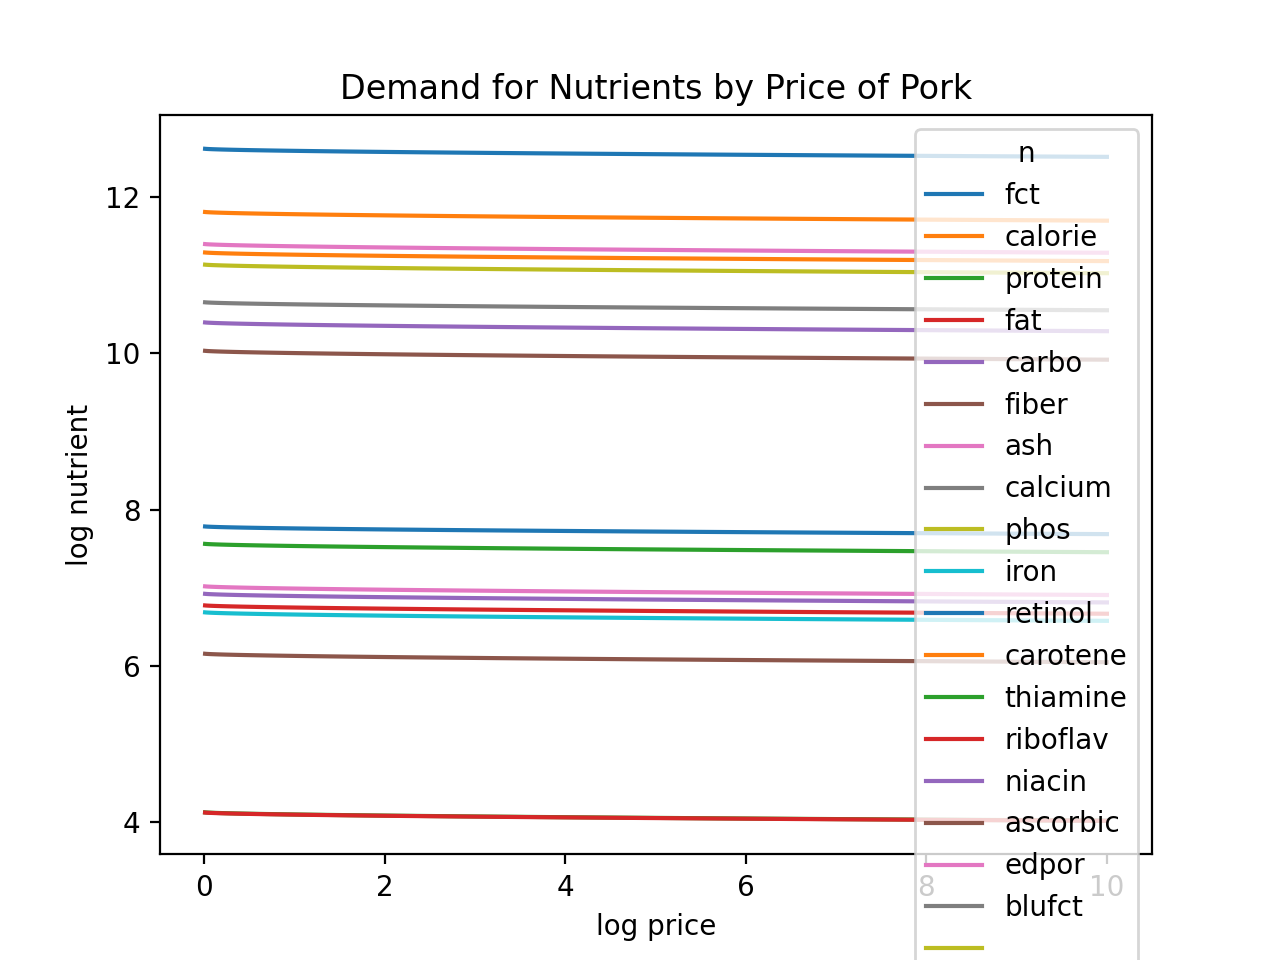

Text(0.5, 1.0, 'Demand for Nutrients by Price of Pork')

In [29]:
USE_GOOD = 'Pork'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')
ax.set_title("Demand for Nutrients by Price of %s" % USE_GOOD)

The above graph makes sense because the nutrient each food have may vary a little, but it should not have great changes depending on the price as should not be a factor that affects nutrients. 

### Nutritional Needs of Households

Considering that our data on demand and nutrients are at household level, we cannot make comparisons to individual level requirement. Therefore, we set up minimum individual requirements to see the household total exceed these. This minimum individual requriement will tell us if all individuals in the household have adequate nutrition.

The rdi defined in our data is categorized by gender and age. This will tell us whether or not 

In [31]:
rdi = get_clean_sheet(Phillippines_Data,
                    sheet='RDI')

Key available for students@eep153.iam.gserviceaccount.com.


/tmp/ipykernel_1247/2540959960.py:8: ResourceWarning:

unclosed <ssl.SSLSocket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.20.2.39', 37018), raddr=('173.194.196.95', 443)>



In [32]:
rdi = rdi.drop(columns = 'units')
rdi = rdi.set_index('n')

In our regression model, d equates to each individual's gender and age range of individual households. The defined dbar below is the average composition of housholds over the given data by gender and age range

In [33]:
#average composition of households by gender and age range
dbar = result.d.mean().iloc[:-2]

In [34]:
dbar

k
Males 0-1         0.094903
Males 1-5         0.277680
Males 5-10        0.256591
Males 10-15       0.325132
Males 15-20       0.363796
Males 20-30       0.975395
Males 30-50       0.862917
Males 50-60       0.209139
Males 60-100      0.163445
Females 0-1       0.072056
Females 1-5       0.233743
Females 5-10      0.286467
Females 10-15     0.307557
Females 15-20     0.369069
Females 20-30     0.810193
Females 30-50     0.806678
Females 50-60     0.223199
Females 60-100    0.135325
dtype: float64

In [35]:
# This matrix product gives minimum nutrient requirements for the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
calorie     13954.253076
protein       381.050967
fat           462.061511
carbo         880.527241
fiber         139.216169
calcium      5701.889279
phos         5210.500879
iron          114.673111
retinol      2879.142355
thiamine        5.783831
riboflav        6.171353
niacin         71.439367
ascorbic      325.641476
dtype: float64

In [36]:
# fiding the average nutritional content for each household
use = fct.index.intersection(qhat_fct.columns)
fct = fct.fillna(0)
nutrients = qhat_fct[use]@fct.loc[use,:]
nutrients = nutrients.drop(columns = ['fct','edpor','blufct','ash','carotene','']) #dropped columns with insufficient data
avg_nutrients = nutrients.mean()/365 # NB: Nutrients are by year
avg_nutrients

n
calorie     19115.069974
protein       686.953242
fat           288.430691
carbo        3376.064550
fiber          39.247315
calcium      4671.093000
phos         9214.243910
iron          138.599359
retinol      2773.631385
thiamine        7.010399
riboflav        7.655856
niacin        189.389227
ascorbic      509.363407
dtype: float64

In [37]:
#rdi diff - household minimum nutrient requirements on average - actual nutrient consumed on average
#allows us to see which category they are deficient in general. 
rdi_diff = hh_rdi - avg_nutrients
rdi_diff

n
calorie    -5160.816898
protein     -305.902276
fat          173.630821
carbo      -2495.537309
fiber         99.968853
calcium     1030.796280
phos       -4003.743032
iron         -23.926248
retinol      105.510970
thiamine      -1.226568
riboflav      -1.484502
niacin      -117.949860
ascorbic    -183.721931
dtype: float64

### Nutritional Adequacy of Food Demands



In [38]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

hh_rdi in the function above represents the recommended dietary intake per household based on composition of each household based on gender and age. Recall that N, defined by nutrient demand function, describes individual household consumption for each food category. Therefore, the nutreint adequacy ratio will be the ratio of actual nutrient intake to recommended nutrient intake. 

This information is useful because it normalizes the nutritional intake to check the adequacy of the diet per household with counts of different kinds of people defined in z, the household characteristics by gender and age range.

<IPython.core.display.Javascript object>


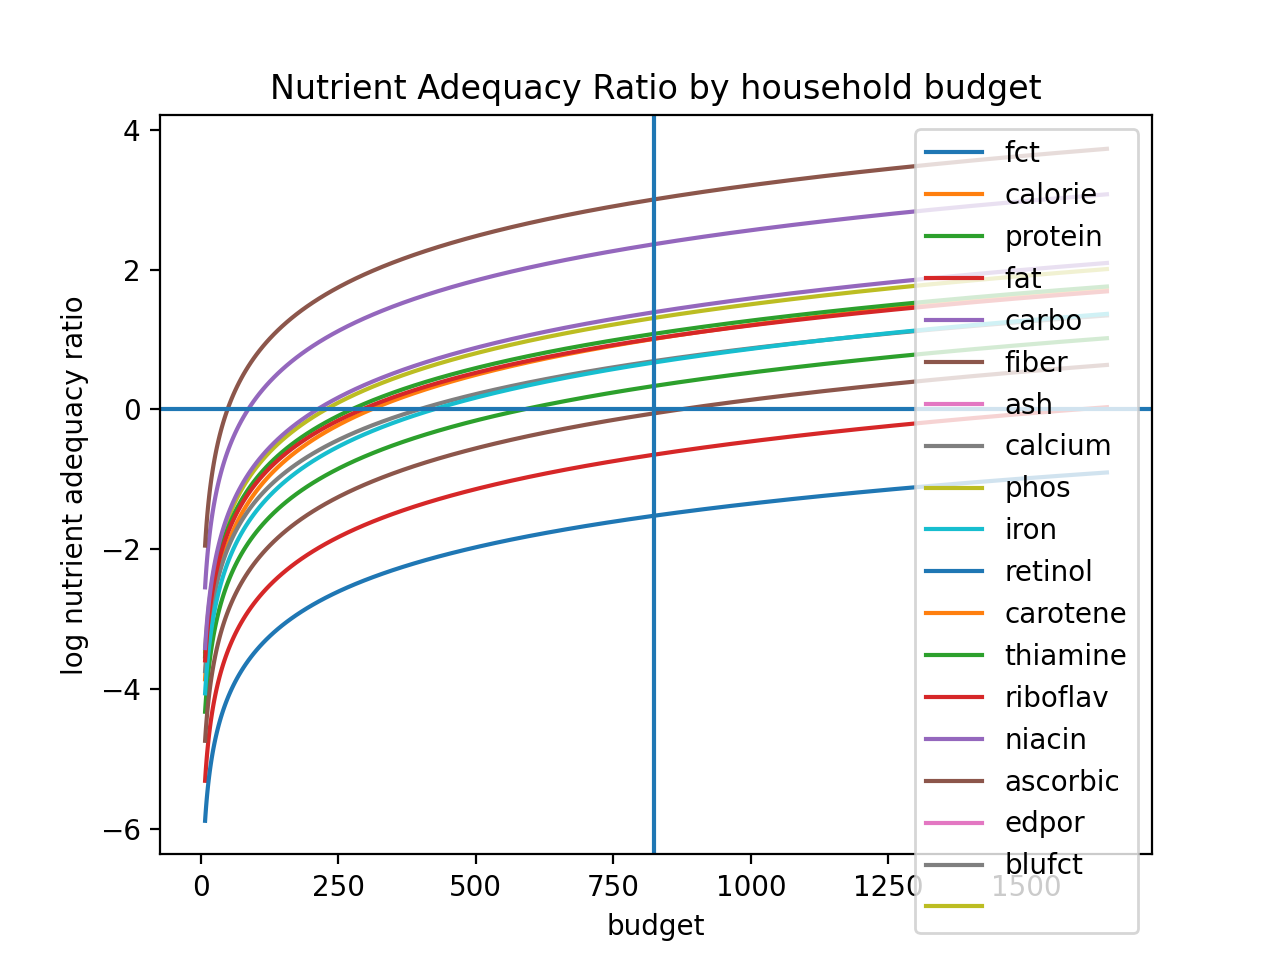

Text(0.5, 1.0, 'Nutrient Adequacy Ratio by household budget')

In [39]:
X = np.geomspace(.01*xref,2*xref,100)
UseNutrients = fct.columns.tolist()
pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)
plt.title("Nutrient Adequacy Ratio by household budget")

We can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good.



<IPython.core.display.Javascript object>


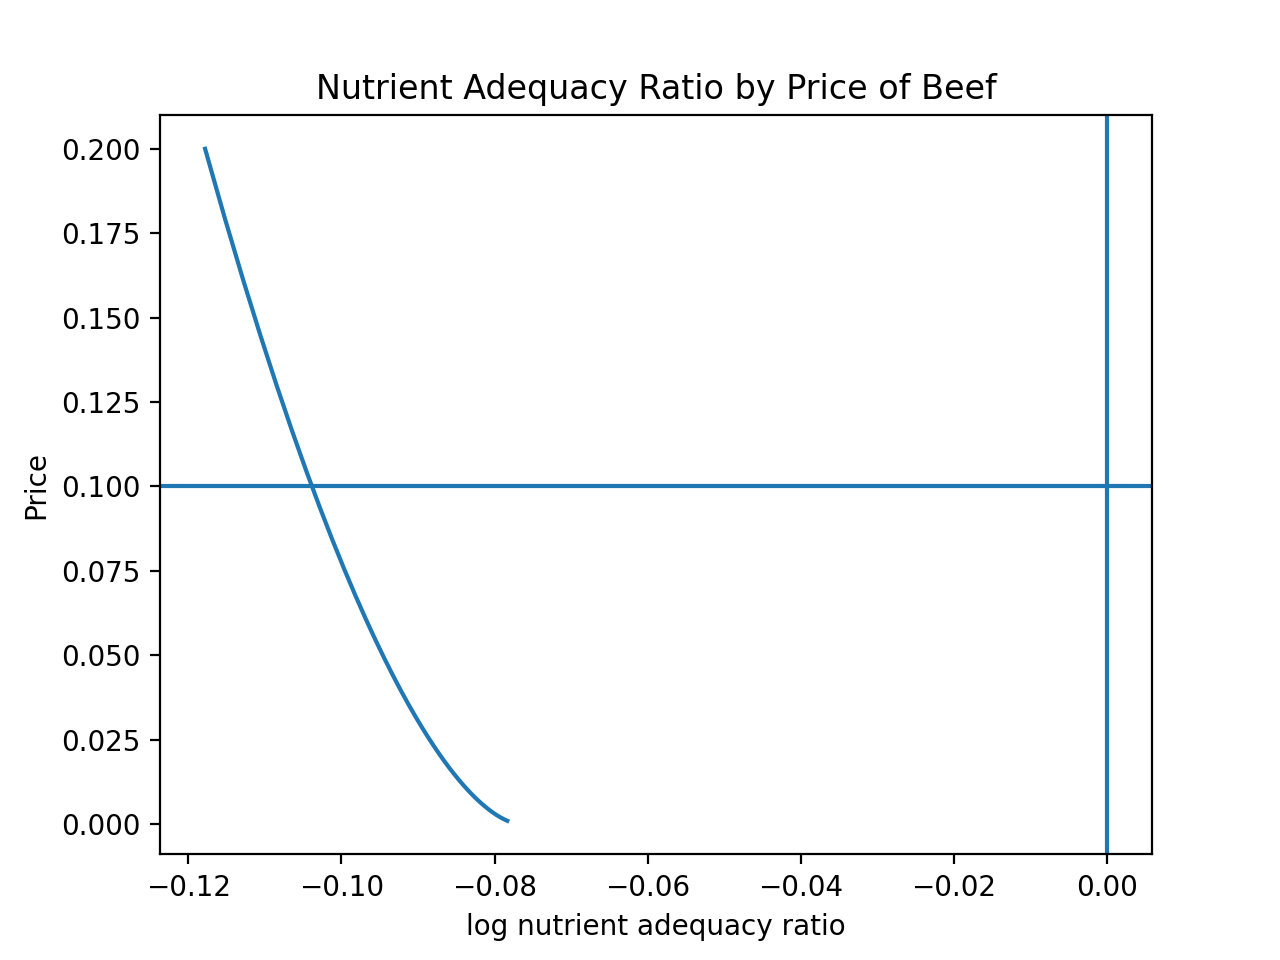

Text(0.5, 1.0, 'Nutrient Adequacy Ratio by Price of Beef')

In [40]:
scale = np.geomspace(.01,2,50)

USE_GOOD = 'Beef'

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['phos'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')
ax.set_title("Nutrient Adequacy Ratio by Price of %s" % USE_GOOD)

### Determining which food items should be subsidized in our economic policy

#### alleviating inadequacies in fat consumption

In [41]:
#consumption function for plotting nutrient consumption based on food types
def consumption (nutrient):
    consumption = qhat_fct[use]
    for col in consumption.columns:
        consumption[col] = consumption[col] * fct[nutrient].loc[col]
    nutrient_df = pd.DataFrame({nutrient: consumption.mean()}).sort_values(by=nutrient, ascending=False)
    fig_nutrient = px.scatter(nutrient_df, x=list(nutrient_df.index), y=nutrient_df[nutrient], title='main ' + nutrient + ' consumption for Bukidnon population')
    fig_nutrient.update_xaxes(title_text='Food Type')
    return fig_nutrient

In [42]:
#high content functino for plotting foods with high nutrients.
def high_content (nutrient):
    high = fct[nutrient]
    high = pd.DataFrame({nutrient: high}).sort_values(by = nutrient, ascending=False)
    fig = px.scatter(high, x=list(high.index), y=high[nutrient], title='high ' + nutrient + ' foods based on FCT')
    fig.update_xaxes(title_text='Food Type')
    return fig

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



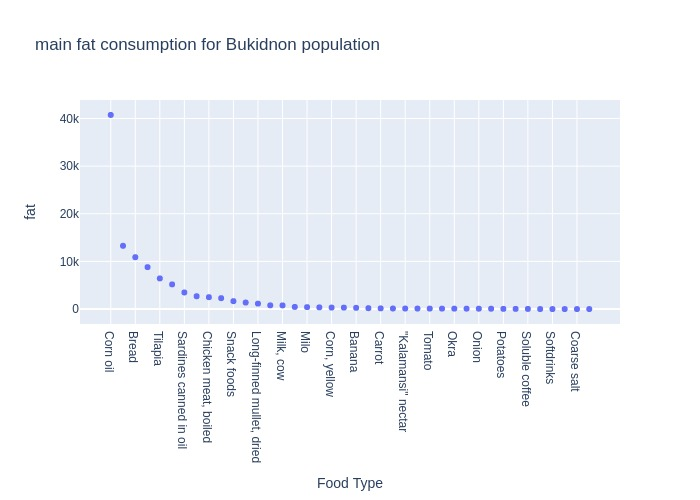

In [44]:
# calculate the fat consumption per household by type of food consumed
fat_consump = consumption('fat')
fat_consump.show('jpg')

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



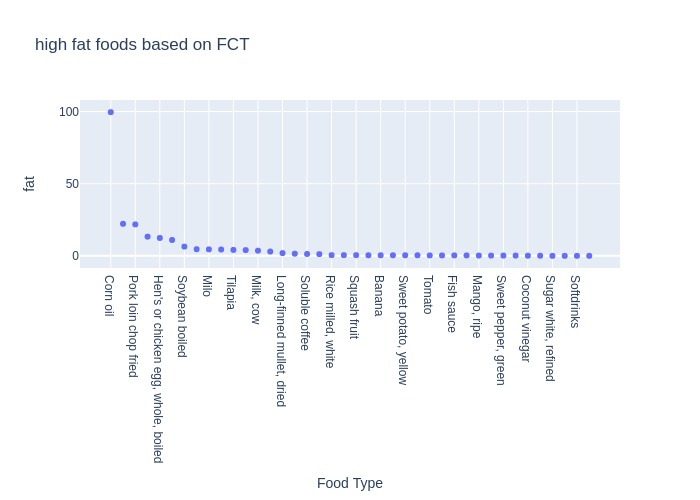

In [43]:
high_fat = high_content('fat')
high_fat.show('jpg')

### alleviating inadequacies in fiber consumption

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



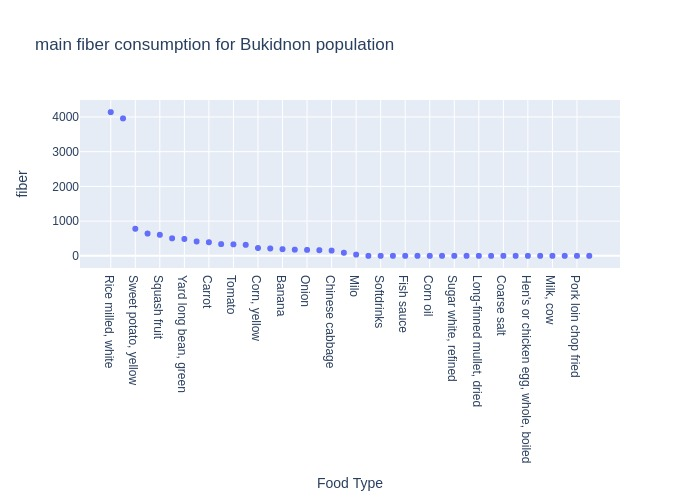

In [47]:
# calculate the fiberconsumption per household by type of food consumed
fiber_consump = consumption('fiber')
fiber_consump.show('jpg')

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



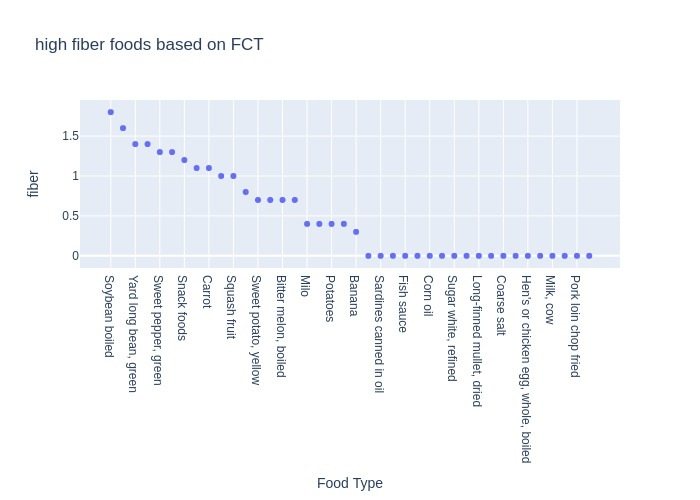

In [48]:
high_fiber = high_content('fiber')
high_fiber.show('jpg')

## other consumption rates 

### phosphorous

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



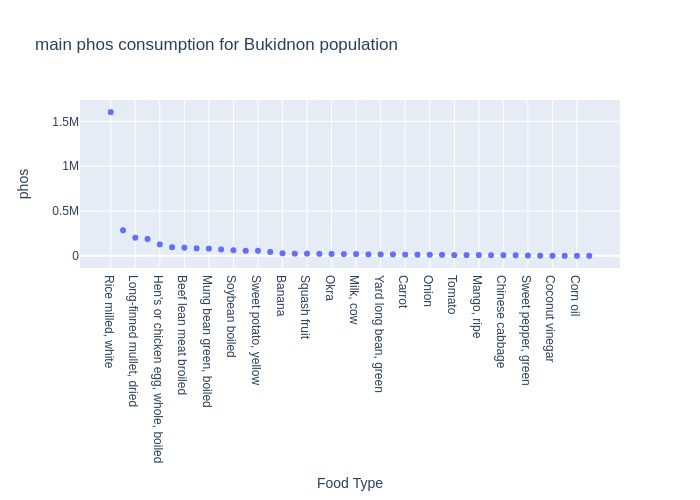

In [49]:
# phosphorous consumption
import plotly.express as px
phosphorous_consump = consumption('phos')
phosphorous_consump.show('jpg')

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



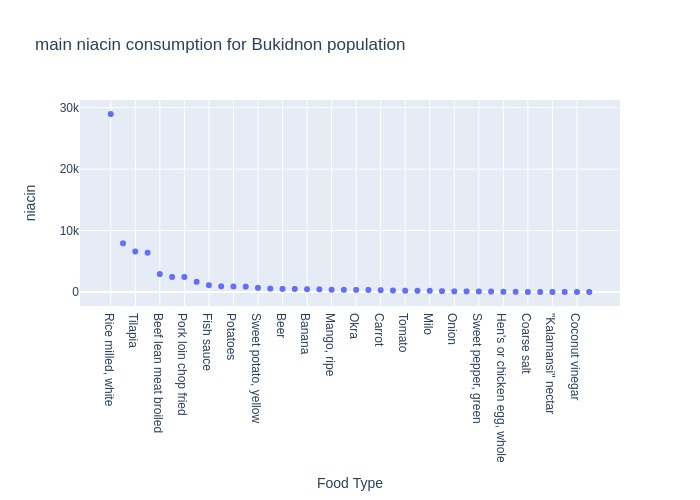

In [50]:
# niacin consumption
import plotly.express as px
niacin_consump = consumption('niacin')
niacin_consump.show('jpg')

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



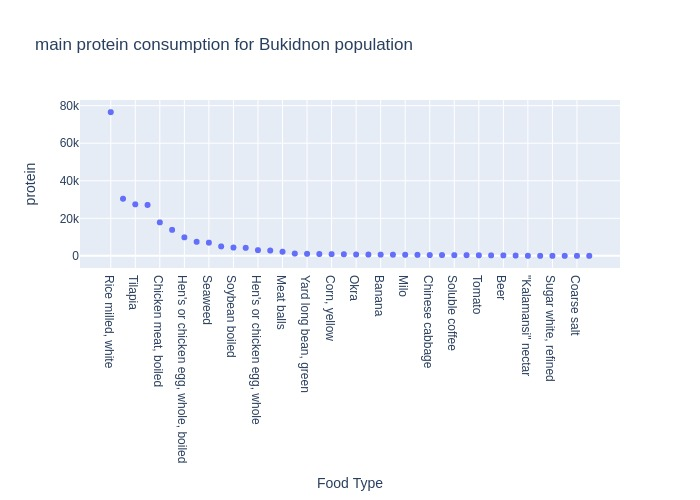

In [51]:
# protein consumption
import plotly.express as px
protein_consump = consumption('protein')
protein_consump.show('jpg')

/opt/conda/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



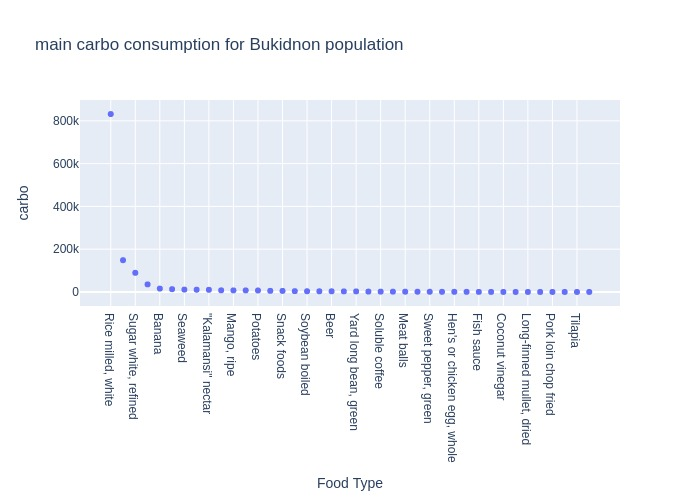

In [52]:
# carbohydrate consumption
import plotly.express as px
carbo_consump = consumption('carbo')
carbo_consump.show('jpg')


### Policy Costs



### Marshallian vs. Hicksian Demand Curves



Text(0.5, 1.0, 'Demand for Pork versus Price')

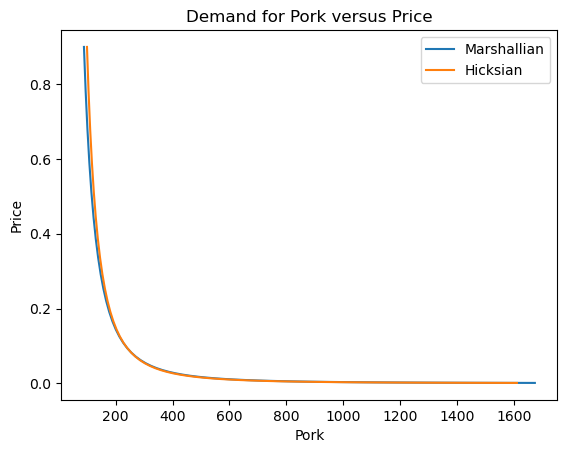

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Pork'

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = result.indirect_utility(xref,pbar)

plt.plot([result.demands(xref,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([result.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))
plt.title("Demand for %s versus Price" % my_j)

In [54]:
def compensating_variation(U0,p0,p1):
    x0 = result.expenditure(U0,p0)
    x1 = result.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = result.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

### Price Changes, Revenue, and Compensating Variation

Examine effects of price changes on revenue (if price change due to a tax or subsidy) and compensating variation.

Text(0.5, 1.0, 'Price of Pork versus Compensating Variation and Revenue')

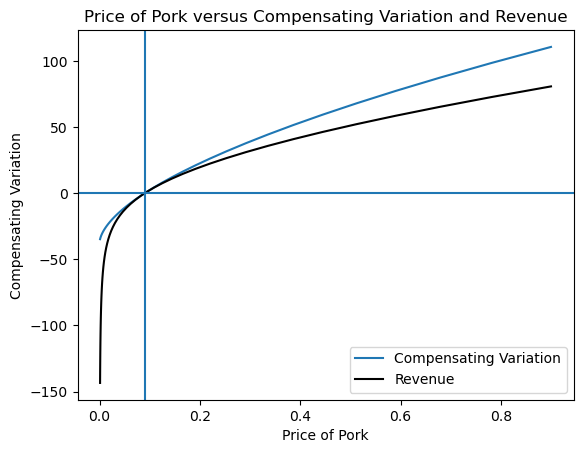

In [55]:
my_j = 'Pork'

fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])
ax1.set_title('Price of Pork versus Compensating Variation and Revenue')

changing the price of "good".
verticle blue = price of 'good' , compensating variation = 'no loss at all'. As we increase the price of 'good', there is an increase in loss of consumer surplus.
Black line = revenue, the revenue line increases at a decreasing rate as we increase the price of the 'good', as people replace the 'good' with some other food surplus.

### Deadweight Loss

Differences between revenue and compensating variation is deadweight-loss:

Text(0.5, 1.0, 'Price of Pork versus Deadweight Loss')

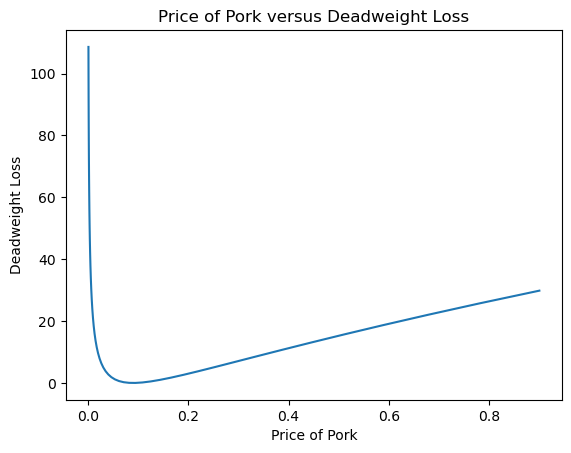

In [56]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")
ax1.set_title("Price of %s versus Deadweight Loss" % my_j)